# Implementing a Multilayer Artificial Neural Network from Scratch 

In [1]:
import os
import struct
import numpy as np

In [2]:
def load_mnist(path, kind = 'train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                              '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, dtype = np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath, dtype = np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
        
    return images, labels

In [3]:
X_train, y_train = load_mnist('', kind = 'train')
print('Rows: %d, Columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, Columns: 784


In [5]:
X_test, y_test = load_mnist('', kind = 't10k')
print('Rows: %d, Columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, Columns: 784


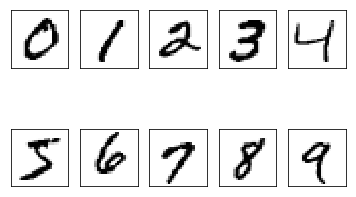

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys')
    
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.show()

Plotting 25 version of the digit '7' to see the variation in the handwriting of different persons

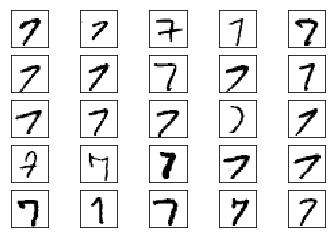

In [8]:
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.show()

In [9]:
np.savez_compressed('mnist_scaled.npz',
                    X_train = X_train,
                    y_train = y_train,
                    X_test = X_test,
                    y_test = y_test)

In [10]:
mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [12]:
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

del mnist
X_train.shape

(60000, 784)